In [ ]:
#Load Data + Create Synthetic Timestamps + Map Categories 

import os
import numpy as np
import pandas as pd

# 1) Determine project root (two levels up from this notebook)
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))

# 2) Point to the training CSV (we’ll ignore the test set for forecasting)
TRAIN_CSV = os.path.join(project_root, "data", "UNSW_NB15_training-set.csv")
print("Loading CSV from:", TRAIN_CSV)

# 3) Read with fallback encoding
try:
    df_logs = pd.read_csv(TRAIN_CSV)
    print("✅ Loaded with default (utf-8) encoding.")
except UnicodeDecodeError:
    print("⚠️ UnicodeDecodeError with utf-8. Retrying with 'latin1' encoding...")
    df_logs = pd.read_csv(TRAIN_CSV, encoding="latin1")
    print("✅ Loaded with 'latin1' encoding.")

# 4) Verify the column names and confirm 'attack_cat' is present
print("\nColumns available in the CSV:")
print(df_logs.columns.tolist())

# 5) Extract only 'attack_cat' (and drop any rows where it is missing)
if "attack_cat" not in df_logs.columns:
    raise KeyError("Expected column 'attack_cat' not found.")
df_cat = df_logs[["attack_cat"]].copy()
df_cat = df_cat.dropna(subset=["attack_cat"]).reset_index(drop=True)
print(f"\nTotal records after dropping missing categories: {len(df_cat)}")

# 6) Create a synthetic timestamp column (one minute apart)
df_cat["timestamp"] = pd.date_range(
    start="2025-01-01", periods=len(df_cat), freq="T"
)

# 7) Set 'timestamp' as the DataFrame index
df_cat = df_cat.set_index("timestamp")

# 8) Map each category string to an integer ID
category_list = sorted(df_cat["attack_cat"].unique().tolist())
cat2idx = {cat: idx for idx, cat in enumerate(category_list)}
idx2cat = {idx: cat for cat, idx in cat2idx.items()}

df_cat["cat_id"] = df_cat["attack_cat"].map(cat2idx)

# 9) Display the mapping and first few rows to confirm
print("\nCategory → ID mapping:", cat2idx)
print("\nFirst 5 rows of df_cat (with synthetic timestamp & cat_id):")
display(df_cat.head())


Loading CSV from: c:\Users\mahas\rogueshield-ai-threat-detector\data\UNSW_NB15_training-set.csv
✅ Loaded with default (utf-8) encoding.

Columns available in the CSV:
['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label']

Total records after dropping missing categories: 82332

Category → ID mapping: {'Analysis': 0, 'Backdoor': 1, 'DoS': 2, 'Exploits': 3, 'Fuzzers': 4, 'Generic': 5, 'Normal': 6, 'Reconnaissance': 7, 'Shellcode': 8, 'Worms': 9}

First 5 rows of df_cat (with synthetic timestamp & cat_id):


C:\Users\mahas\AppData\Local\Temp\ipykernel_10552\541139090.py:35: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_cat["timestamp"] = pd.date_range(


,attack_cat,cat_id
timestamp,,
2025-01-01 00:00:00,Normal,6
2025-01-01 00:01:00,Normal,6
2025-01-01 00:02:00,Normal,6
2025-01-01 00:03:00,Normal,6
2025-01-01 00:04:00,Normal,6


In [ ]:
#One‐Hot Encode & Resample Hourly 
import pandas as pd

# One‐hot encode 'cat_id' to create C columns (cat_0, cat_1, …)
num_categories = len(cat2idx)  # C
one_hot = pd.get_dummies(df_cat["cat_id"], prefix="cat")

# Merge one‐hot columns with df_cat (which currently has only 'attack_cat' & 'cat_id')
df_onehot = pd.concat([df_cat, one_hot], axis=1)

# Drop columns we no longer need for aggregation

onehot_cols = [f"cat_{i}" for i in range(num_categories)]
df_onehot = df_onehot[onehot_cols]

# 3) Resample by hour, summing up the one‐hot indicators
ts_hourly = df_onehot.resample("H").sum().fillna(0).astype(int)

# 4) Display the first few rows and shape
print("Hourly category‐count DataFrame (first 5 rows):")
display(ts_hourly.head())
print("\nts_hourly shape:", ts_hourly.shape)


Hourly category‐count DataFrame (first 5 rows):


C:\Users\mahas\AppData\Local\Temp\ipykernel_10552\2145229828.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_hourly = df_onehot.resample("H").sum().fillna(0).astype(int)


,cat_0,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,cat_7,cat_8,cat_9
timestamp,,,,,,,,,,
2025-01-01 00:00:00,0,0,0,0,0,0,60,0,0,0
2025-01-01 01:00:00,0,0,0,0,0,0,60,0,0,0
2025-01-01 02:00:00,0,0,0,0,0,0,60,0,0,0
2025-01-01 03:00:00,0,0,0,0,0,0,60,0,0,0
2025-01-01 04:00:00,1,1,2,26,14,0,3,13,0,0



ts_hourly shape: (1373, 10)


In [16]:
#  Build Sliding-Window Sequences & Split into Train/Val/Test


import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the sliding-window function.
def build_category_sequences(df_counts: pd.DataFrame, sequence_length: int = 24):
    """
    Build supervised sequences from hourly category-count DataFrame.

    Args:
      df_counts (pd.DataFrame): Hourly counts, shape (N, C).
      sequence_length (int): Number of past hours to use for prediction.

    Returns:
      X (np.ndarray): Shape (N - sequence_length, sequence_length, C).
      y (np.ndarray): Shape (N - sequence_length, C), counts for the next hour.
    """
    data = df_counts.values      # Convert DataFrame to NumPy array, shape (N, C)
    N, C = data.shape            # N = number of hours, C = number of categories
    
    sequences = []                # List to accumulate each X_i of shape (T, C)
    targets = []                  # List to accumulate each y_i of shape (C,)
    
    # For each possible window starting index, collect a sequence and its next-hour target.
    #    We stop at N - sequence_length - 1, because index i+sequence_length must be < N.
    for start_idx in range(0, N - sequence_length):
        end_idx = start_idx + sequence_length
        
        # X_i: the block of hours [start_idx : end_idx) (T rows, C columns)
        X_i = data[start_idx : end_idx, :]    # shape (sequence_length, C)
        
        # y_i: the counts at hour index end_idx (the next hour after the sequence)
        y_i = data[end_idx, :]                # shape (C,)
        
        sequences.append(X_i)
        targets.append(y_i)
    
    # Stack the lists into NumPy arrays
    X = np.stack(sequences, axis=0)  # shape (num_samples, sequence_length, C)
    y = np.stack(targets, axis=0)    # shape (num_samples, C)
    
    return X, y

# Choose the window length T. Common choice is 24 hours (past day).
T = 24

# Build all sequences and targets from ts_hourly
X_all, y_all = build_category_sequences(ts_hourly, sequence_length=T)
print("All sequences X_all shape:", X_all.shape)   # e.g. (num_samples, 24, 10)
print("All targets y_all shape:", y_all.shape)     # e.g. (num_samples, 10)

# Split into Train / Validation / Test (70% / 15% / 15%) with shuffling.
#    First split off 15% for the final test set.
X_temp, X_test, y_temp, y_test = train_test_split(
    X_all, y_all, test_size=0.15, random_state=42, shuffle=True
)

# From the remaining 85%, split 17.6% (~15% of total) as validation
val_fraction_of_temp = 0.15 / (1 - 0.15)  # ≈0.176
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_fraction_of_temp,
    random_state=42,
    shuffle=True
)

# Print shapes to verify
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape},   y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape},  y_test:  {y_test.shape}")

# (Optional) Save these arrays to disk for faster reloading in scripts
output_dir = os.path.join(os.getcwd(), "data", "processed", "agg_category_forecast")
os.makedirs(output_dir, exist_ok=True)
np.save(os.path.join(output_dir, "X_train.npy"), X_train)
np.save(os.path.join(output_dir, "y_train.npy"), y_train)
np.save(os.path.join(output_dir, "X_val.npy"),   X_val)
np.save(os.path.join(output_dir, "y_val.npy"),   y_val)
np.save(os.path.join(output_dir, "X_test.npy"),  X_test)
np.save(os.path.join(output_dir, "y_test.npy"),  y_test)

print("\n✅ Saved sequences & targets under data/processed/agg_category_forecast/")



All sequences X_all shape: (1349, 24, 10)
All targets y_all shape: (1349, 10)
X_train: (943, 24, 10), y_train: (943, 10)
X_val:   (203, 24, 10),   y_val:   (203, 10)
X_test:  (203, 24, 10),  y_test:  (203, 10)

✅ Saved sequences & targets under data/processed/agg_category_forecast/


X_train: (943, 24, 10), y_train: (943, 10)
X_val:   (203, 24, 10),   y_val:   (203, 10)
X_test:  (203, 24, 10),  y_test:  (203, 10)
Sequence length (T): 24, Num categories (C): 10


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,106 (78.54 KB)

 Trainable params: 19,978 (78.04 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 263.5154 - mean_absolute_error: 6.6355 - val_loss: 242.9419 - val_mean_absolute_error: 6.1766 - learning_rate: 0.0010
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 224.9726 - mean_absolute_error: 6.3372 - val_loss: 224.7843 - val_mean_absolute_error: 6.1659 - learning_rate: 0.0010
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 202.3713 - mean_absolute_error: 6.2025 - val_loss: 204.4887 - val_mean_absolute_error: 6.0505 - learning_rate: 0.0010
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 180.5869 - mean_absolute_error: 6.1460 - val_loss: 183.9563 - val_mean_absolute_error: 5.9864 - learning_rate: 0.0010
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 162.6202 - mean_absolute_error: 6.0801 - val_loss: 167.4199 - val_mean_absolute_error: 5.8344 - learning_rate: 0.0010
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 145.9612 - mean_absolute_error: 5.9807 - val_loss: 148.4178 -

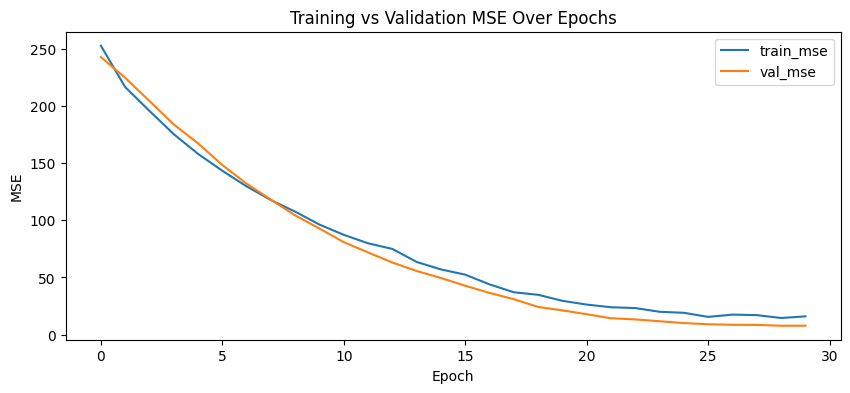

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3240 - mean_absolute_error: 1.1712 

Test MSE: 6.29, Test MAE: 1.16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


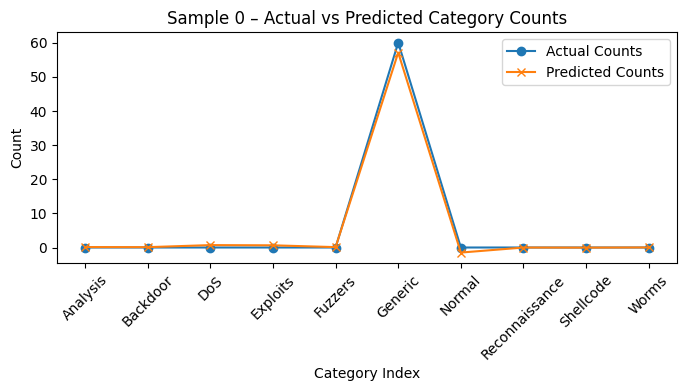

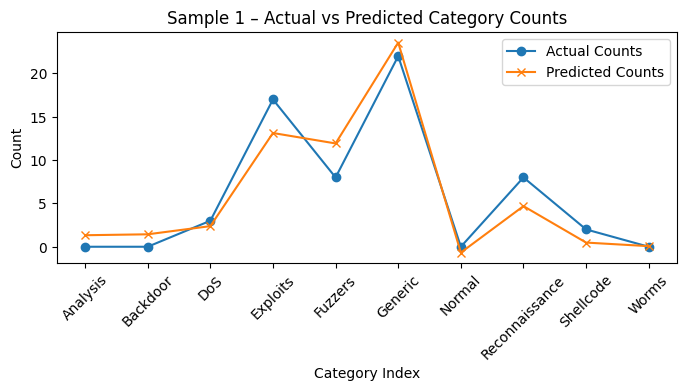

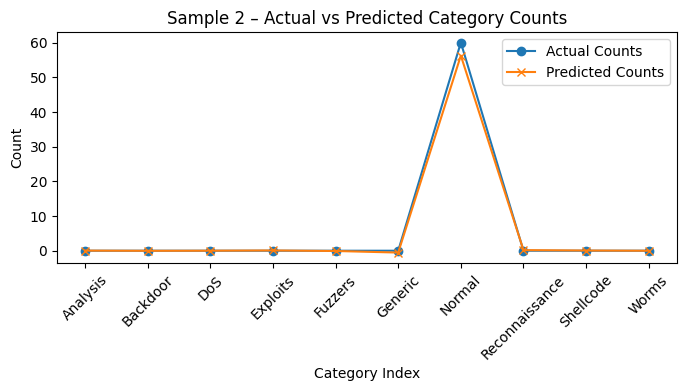


✅ Saved model to models/category_forecast/lstm_category_forecast.h5


In [ ]:
# Build, Compile, and Train the LSTM Forecast Model

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks


# Load the saved NumPy arrays from Step B.4

base_dir = os.path.join(os.getcwd(), "data", "processed", "agg_category_forecast")
X_train = np.load(os.path.join(base_dir, "X_train.npy")).astype(np.float32)
y_train = np.load(os.path.join(base_dir, "y_train.npy")).astype(np.float32)
X_val   = np.load(os.path.join(base_dir, "X_val.npy")).astype(np.float32)
y_val   = np.load(os.path.join(base_dir, "y_val.npy")).astype(np.float32)
X_test  = np.load(os.path.join(base_dir, "X_test.npy")).astype(np.float32)
y_test  = np.load(os.path.join(base_dir, "y_test.npy")).astype(np.float32)

# Print shapes to confirm we loaded correctly
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape},   y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape},  y_test:  {y_test.shape}")


#Build tf.data.Dataset pipelines for training, validation, and testing

BATCH_SIZE = 32

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(buffer_size=len(X_train))   # shuffle the training data each epoch
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)          # prefetch for performance
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


# Define the LSTM model architecture

# Determine input dimensions from the data:
sequence_length, num_categories = X_train.shape[1], X_train.shape[2]
print(f"Sequence length (T): {sequence_length}, Num categories (C): {num_categories}")

def build_lstm_forecast_model(
    input_shape=(sequence_length, num_categories),
    lstm_units=64,
    dropout_rate=0.3,
    learning_rate=1e-3
):
    """
    Constructs and compiles a TensorFlow LSTM model for forecasting category counts.
    Architecture:
      1) LSTM layer with 'lstm_units' units
      2) BatchNormalization
      3) Dropout
      4) Dense layer with 'num_categories' units (linear activation) to predict next-hour counts
    """
    inputs = layers.Input(shape=input_shape)
    
    # LSTM layer (no return_sequences since we want final output only)
    x = layers.LSTM(units=lstm_units)(inputs)
    
    # BatchNormalization to stabilize and accelerate training
    x = layers.BatchNormalization()(x)
    
    # Dropout for regularization, to reduce overfitting
    x = layers.Dropout(rate=dropout_rate)(x)
    
    # Final Dense layer outputs one value per category
    outputs = layers.Dense(units=num_categories, activation="linear")(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    
    # Compile with mean squared error loss and report mean absolute error metric
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    return model

# Build the model and display its summary
model_cat = build_lstm_forecast_model(input_shape=(sequence_length, num_categories))
model_cat.summary()


#Set up training callbacks

# Reduce the learning rate by factor 0.5 if validation loss plateaus for 3 epochs
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, verbose=1
)

# Stop training early if validation loss does not improve for 7 epochs
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=7, restore_best_weights=True, verbose=1
)


# Train the model

EPOCHS = 30
history = model_cat.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[reduce_lr, early_stop]
)

# Plot training & validation MSE curves
plt.figure(figsize=(10, 4))
plt.plot(history.history["loss"], label="train_mse")
plt.plot(history.history["val_loss"], label="val_mse")
plt.title("Training vs Validation MSE Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()


# Evaluate on the test set

test_metrics = model_cat.evaluate(test_ds)
print(f"\nTest MSE: {test_metrics[0]:.2f}, Test MAE: {test_metrics[1]:.2f}")


# Quick visualization: compare actual vs predicted counts for 3 test samples

X_test_sample = X_test[:3]            # shape (3, 24, C)
y_true_sample = y_test[:3]            # shape (3, C)
y_pred_sample = model_cat.predict(X_test_sample)  # shape (3, C)

for idx in range(3):
    plt.figure(figsize=(8, 3))
    plt.plot(y_true_sample[idx], label="Actual Counts", marker="o")
    plt.plot(y_pred_sample[idx], label="Predicted Counts", marker="x")
    plt.title(f"Sample {idx} – Actual vs Predicted Category Counts")
    plt.xlabel("Category Index")
    plt.ylabel("Count")
    plt.xticks(
        ticks=list(range(num_categories)),
        labels=[idx2cat[i] for i in range(num_categories)],
        rotation=45
    )
    plt.legend()
    plt.show()


# Save the trained model for future use (e.g., explainability or Streamlit)

model_dir = os.path.join(os.getcwd(), "models", "category_forecast")
os.makedirs(model_dir, exist_ok=True)
model_cat.save(os.path.join(model_dir, "lstm_category_forecast.h5"))
print("\n✅ Saved model to models/category_forecast/lstm_category_forecast.h5")


In [ ]:
# Prepare “dur” Sequences for Forecasting Next Connection Duration 

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

#  Determine project root (two levels up from this notebook)
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))

#  Path to the UNSW-NB15 training CSV
TRAIN_CSV = os.path.join(project_root, "data", "UNSW_NB15_training-set.csv")
print("Loading data from:", TRAIN_CSV)

#  Read with fallback encoding
try:
    df_raw = pd.read_csv(TRAIN_CSV)
    print("✅ Loaded with default (utf-8) encoding.")
except UnicodeDecodeError:
    print("⚠️ UnicodeDecodeError with utf-8. Retrying with 'latin1' encoding...")
    df_raw = pd.read_csv(TRAIN_CSV, encoding="latin1")
    print("✅ Loaded with 'latin1' encoding.")

# Verify that the 'dur' column exists
if "dur" not in df_raw.columns:
    raise KeyError("Expected column 'dur' not found in the CSV.")

# Extract only the 'dur' column, drop missing values if any
df_dur = df_raw[["dur"]].dropna().reset_index(drop=True)
print(f"\nTotal records of 'dur' after dropping nulls: {len(df_dur)}")

# Create a synthetic timestamp (one minute apart) so that each row gets a unique DatetimeIndex
# start on 2025-01-01 00:00 and increment minute by minute.
df_dur["timestamp"] = pd.date_range(start="2025-01-01", periods=len(df_dur), freq="T")

# Set 'timestamp' as the DataFrame index for any future time‐based operations
df_dur = df_dur.set_index("timestamp")

# Display the first few rows of df_dur to confirm
print("\nFirst 5 rows of df_dur (duration + synthetic timestamp):")
display(df_dur.head())

# Define a function to build sliding windows of length T (e.g., T = 24 durations)
def build_duration_sequences(df_duration: pd.DataFrame, sequence_length: int = 24):
    """
    Converts a 1D series of duration values (indexed by time) into
    supervised training samples for forecasting the next 'dur'.
    
    Each sample uses the previous `sequence_length` durations to predict the next one.
    
    Returns:
      X (np.ndarray): shape (num_samples, sequence_length, 1)
      y (np.ndarray): shape (num_samples, 1)
    """
    data = df_duration["dur"].values.astype(np.float32)  # shape (N,)
    N = len(data)
    sequences = []
    targets = []
    
    # For each i from sequence_length up to N-1, use
    #   X_i = data[i-sequence_length : i] (last T durations)
    #   y_i = data[i]                     (the next duration)
    for i in range(sequence_length, N):
        X_i = data[i - sequence_length : i]   # shape (T,)
        y_i = data[i]                         # scalar
        sequences.append(X_i.reshape(sequence_length, 1))  # reshape → (T,1)
        targets.append(y_i)
    
    X = np.stack(sequences, axis=0)  # shape (N - sequence_length, T, 1)
    y = np.array(targets, dtype=np.float32).reshape(-1, 1)  # shape (N - sequence_length, 1)
    return X, y

# Choose window length T (e.g., 24 durations → last 24 minutes)
T = 24

#  Build sequences (X_all, y_all)
X_all, y_all = build_duration_sequences(df_dur, sequence_length=T)
print("\nAll sequences X_all shape:", X_all.shape)  # e.g. (num_samples, 24, 1)
print("All targets y_all shape:", y_all.shape)       # (num_samples, 1)

# Split into Train / Val / Test (70% / 15% / 15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_all, y_all, test_size=0.15, random_state=42, shuffle=True
)
val_fraction = 0.15 / 0.85  # ≈ 0.176 (so validation ends up being ~15% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_fraction, random_state=42, shuffle=True
)

print(f"\nX_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape},   y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape},  y_test:  {y_test.shape}")

# Save these arrays to disk so a later script can load them quickly
out_dir = os.path.join(os.getcwd(), "data", "processed", "time_to_next_dur")
os.makedirs(out_dir, exist_ok=True)
np.save(os.path.join(out_dir, "X_train.npy"), X_train)
np.save(os.path.join(out_dir, "y_train.npy"), y_train)
np.save(os.path.join(out_dir, "X_val.npy"),   X_val)
np.save(os.path.join(out_dir, "y_val.npy"),   y_val)
np.save(os.path.join(out_dir, "X_test.npy"),  X_test)
np.save(os.path.join(out_dir, "y_test.npy"),  y_test)

print("\n✅ Saved duration sequences under data/processed/time_to_next_dur/")


Loading data from: c:\Users\mahas\rogueshield-ai-threat-detector\data\UNSW_NB15_training-set.csv
✅ Loaded with default (utf-8) encoding.

Total records of 'dur' after dropping nulls: 82332

First 5 rows of df_dur (duration + synthetic timestamp):


C:\Users\mahas\AppData\Local\Temp\ipykernel_10552\2521796080.py:34: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_dur["timestamp"] = pd.date_range(start="2025-01-01", periods=len(df_dur), freq="T")


,dur
timestamp,
2025-01-01 00:00:00,0.000011
2025-01-01 00:01:00,0.000008
2025-01-01 00:02:00,0.000005
2025-01-01 00:03:00,0.000006
2025-01-01 00:04:00,0.000010



All sequences X_all shape: (82308, 24, 1)
All targets y_all shape: (82308, 1)

X_train: (57614, 24, 1), y_train: (57614, 1)
X_val:   (12347, 24, 1),   y_val:   (12347, 1)
X_test:  (12347, 24, 1),  y_test:  (12347, 1)

✅ Saved duration sequences under data/processed/time_to_next_dur/


In [ ]:
#  Improved LSTM/GRU Model with Log‐Transform & Normalization 

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split


proj_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
train_csv = os.path.join(proj_root, "data", "UNSW_NB15_training-set.csv")
print("Loading CSV from:", train_csv)


# Read CSV with fallback encoding
try:
    df_raw = pd.read_csv(train_csv)
    print("✅ Loaded CSV with utf-8")
except UnicodeDecodeError:
    print("⚠️ UnicodeDecodeError, retrying with latin1")
    df_raw = pd.read_csv(train_csv, encoding="latin1")
    print("✅ Loaded CSV with latin1")


# Ensure 'dur' exists and drop missing
if "dur" not in df_raw.columns:
    raise KeyError("'dur' column not found")
df_dur = df_raw[["dur"]].dropna().reset_index(drop=True)
print("Total dur records:", len(df_dur))

# Apply log1p transform
dur_raw = df_dur["dur"].astype(np.float32).values
dur_log = np.log1p(dur_raw)

# Assign synthetic 1-minute timestamps
df_dur["timestamp"] = pd.date_range(start="2025-01-01", periods=len(df_dur), freq="min")
df_dur = df_dur.set_index("timestamp")
df_dur["dur_log"] = dur_log

# Compute mean & std from first 80% for normalization
split_idx = int(0.8 * len(dur_log))
mean_log = dur_log[:split_idx].mean()
std_log = dur_log[:split_idx].std()
print(f"Log1p(dur) mean: {mean_log:.6f}, std: {std_log:.6f}")




Loading CSV from: c:\Users\mahas\rogueshield-ai-threat-detector\data\UNSW_NB15_training-set.csv
✅ Loaded CSV with utf-8
Total dur records: 82332
Log1p(dur) mean: 0.285933, std: 0.563566


In [26]:
#Build & Split Normalized Sliding‐Window Sequences 

from sklearn.model_selection import train_test_split

def build_sequences_log_norm(df_duration: pd.DataFrame, mean: float, std: float, T: int = 24):
    """
    Converts the 'dur_log' column into supervised sequences.
    Args:
      df_duration: DataFrame indexed by timestamp with column 'dur_log'.
      mean: float, training‐set mean of log1p(dur).
      std:  float, training‐set std of log1p(dur).
      T:    int, window length (number of past steps).
    Returns:
      X: np.ndarray, shape (N−T, T, 1) of normalized log1p(dur) sequences.
      y: np.ndarray, shape (N−T, 1) of next-step normalized log1p(dur) targets.
    """
    values = df_duration["dur_log"].values.astype(np.float32)  # shape (N,)
    N = len(values)
    sequences, targets = [], []
    for i in range(T, N):
        window = values[i - T : i]                          # shape (T,)
        y_val = values[i]                                    # scalar

        # Normalize window and target: (value - mean) / std
        X_i = ((window - mean) / std).reshape(T, 1)         # shape (T,1)
        y_i = np.array([(y_val - mean) / std], dtype=np.float32)  # shape (1,)

        sequences.append(X_i)
        targets.append(y_i)

    X = np.stack(sequences, axis=0)  # shape (num_samples, T, 1)
    y = np.vstack(targets)           # shape (num_samples, 1)
    return X, y

# Build sequences with T=24
T = 24
X_all, y_all = build_sequences_log_norm(df_dur, mean_log, std_log, T)
print("All sequences shape:", X_all.shape, "All targets shape:", y_all.shape)

# Split into Train/Val/Test: 70% / 15% / 15%
X_temp, X_test, y_temp, y_test = train_test_split(
    X_all, y_all, test_size=0.15, random_state=42, shuffle=True
)
val_frac = 0.15 / 0.85  # ≈0.176
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_frac, random_state=42, shuffle=True
)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

# Save normalized sequences
out_dir = os.path.join(proj_root, "data", "processed", "time_to_next_dur_norm")
os.makedirs(out_dir, exist_ok=True)
np.save(os.path.join(out_dir, "X_train.npy"), X_train)
np.save(os.path.join(out_dir, "y_train.npy"), y_train)
np.save(os.path.join(out_dir, "X_val.npy"),   X_val)
np.save(os.path.join(out_dir, "y_val.npy"),   y_val)
np.save(os.path.join(out_dir, "X_test.npy"),  X_test)
np.save(os.path.join(out_dir, "y_test.npy"),  y_test)
print("✅ Saved normalized sequences under:", out_dir)


All sequences shape: (82308, 24, 1) All targets shape: (82308, 1)
X_train: (57614, 24, 1) y_train: (57614, 1)
X_val: (12347, 24, 1) y_val: (12347, 1)
X_test: (12347, 24, 1) y_test: (12347, 1)
✅ Saved normalized sequences under: c:\Users\mahas\rogueshield-ai-threat-detector\data\processed\time_to_next_dur_norm


In [27]:
# Build tf.data.Dataset Pipelines 

import tensorflow as tf

BATCH_SIZE = 64

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(buffer_size=len(X_train))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Confirm shapes from one batch
for x_batch, y_batch in train_ds.take(1):
    print("Batch X shape:", x_batch.shape, " dtype:", x_batch.dtype)
    print("Batch y shape:", y_batch.shape, " dtype:", y_batch.dtype)


Batch X shape: (64, 24, 1)  dtype: <dtype: 'float32'>
Batch y shape: (64, 1)  dtype: <dtype: 'float32'>


In [28]:
# Define & Compile Improved GRU Model 

from tensorflow.keras import layers, models, optimizers

sequence_length, feature_dim = X_train.shape[1], X_train.shape[2]
print("Sequence length:", sequence_length, "Feature dim:", feature_dim)

def build_gru_duration_model(input_shape=(sequence_length, feature_dim),
                             gru_units=64, dropout_rate=0.3, learning_rate=1e-3):
    """
    Constructs a GRU-based model to predict normalized log1p(dur).
    """
    inp = layers.Input(shape=input_shape)
    x = layers.GRU(units=gru_units)(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate=dropout_rate)(x)
    out = layers.Dense(units=1, activation="linear")(x)
    model = models.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss="huber",
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    return model

model_dur = build_gru_duration_model(
    input_shape=(sequence_length, feature_dim),
    gru_units=64,
    dropout_rate=0.3,
    learning_rate=1e-3
)
model_dur.summary()


Sequence length: 24 Feature dim: 1


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,185 (51.50 KB)

 Trainable params: 13,057 (51.00 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.3064 - mean_absolute_error: 0.6053 - val_loss: 0.2604 - val_mean_absolute_error: 0.5935 - learning_rate: 0.0010
Epoch 2/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.2363 - mean_absolute_error: 0.4988 - val_loss: 0.2278 - val_mean_absolute_error: 0.4566 - learning_rate: 0.0010
Epoch 3/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.2339 - mean_absolute_error: 0.4972 - val_loss: 0.2200 - val_mean_absolute_error: 0.4695 - learning_rate: 0.0010
Epoch 4/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.2338 - mean_absolute_error: 0.4956 - val_loss: 0.2224 - val_mean_absolute_error: 0.5092 - learning_rate: 0.0010
Epoch 5/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.2333 - mean_absolute_error: 0.4953 - val_loss: 0.2219 - val_mean_absolute_error: 0.4534 - learning_rate: 0.0010
Epoch 6/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2385 - mean_absolute_error: 0.4999
Epoch 6: ReduceLROnPlateau reduci

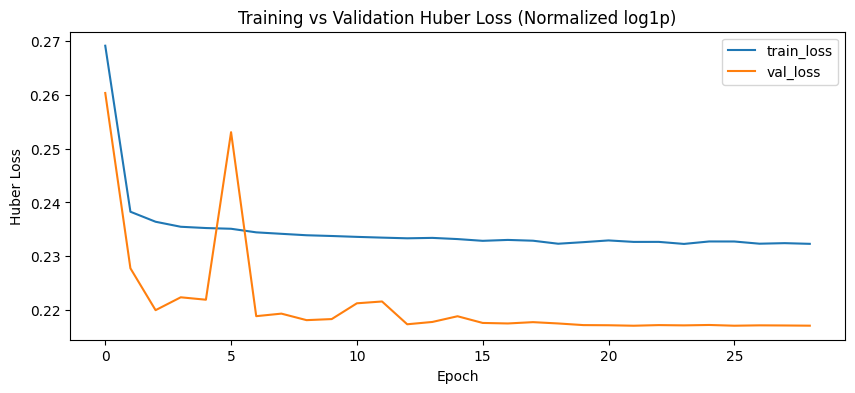

In [ ]:
# Train the GRU Model with Callbacks 

from tensorflow.keras import callbacks

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, verbose=1
)
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=7, restore_best_weights=True, verbose=1
)

EPOCHS = 30
history = model_dur.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[reduce_lr, early_stop]
)




In [ ]:
# Plot training & validation loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Training vs Validation Huber Loss (Normalized log1p)")
plt.xlabel("Epoch")
plt.ylabel("Huber Loss")
plt.legend()

# Save loss curve
loss_plot_rel = os.path.join("notebooks", "forecasting", "loss_duration_forecast.png")
loss_plot_path = os.path.join(proj_root, loss_plot_rel)
os.makedirs(os.path.dirname(loss_plot_path), exist_ok=True)
plt.savefig(loss_plot_path, dpi=300, bbox_inches="tight")
plt.close()
print(f"✅ Saved loss curve to: {loss_plot_path}")

✅ Saved loss curve to: c:\Users\mahas\rogueshield-ai-threat-detector\notebooks\forecasting\loss_duration_forecast.png


In [31]:
#Evaluate & Visualize Predictions (Raw Seconds) 

# Evaluate on test set (normalized)
test_metrics = model_dur.evaluate(test_ds)
print(f"\nTest Huber Loss (normalized): {test_metrics[0]:.6f}, Test MAE (normalized): {test_metrics[1]:.6f}")

# Predict first 5 samples
y_pred_norm = model_dur.predict(X_test[:5])
y_true_norm = y_test[:5]

# Invert normalization and log1p to raw seconds
y_true_raw = np.expm1(y_true_norm * std_log + mean_log)
y_pred_raw = np.expm1(y_pred_norm * std_log + mean_log)

sample_dir_rel = os.path.join("notebooks", "forecasting", "samples")
sample_dir_abs = os.path.join(proj_root, sample_dir_rel)
os.makedirs(sample_dir_abs, exist_ok=True)

for idx in range(5):
    actual_dur = y_true_raw[idx, 0]
    pred_dur   = y_pred_raw[idx, 0]

    plt.figure(figsize=(5, 3))
    plt.plot([0, 1], [actual_dur, pred_dur], 'o-')
    plt.xticks([0, 1], ["Actual (sec)", "Predicted (sec)"])
    plt.ylabel("Connection Duration (sec)")
    plt.title(f"Sample {idx} – Actual vs Predicted dur")
    plt.grid(True)

    sample_filename = f"pred_actual_dur_sample_{idx}.png"
    sample_path = os.path.join(sample_dir_abs, sample_filename)
    plt.savefig(sample_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"✅ Saved sample {idx} plot to: {sample_path}")


193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2306 - mean_absolute_error: 0.4896

Test Huber Loss (normalized): 0.229145, Test MAE (normalized): 0.487339


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
✅ Saved sample 0 plot to: c:\Users\mahas\rogueshield-ai-threat-detector\notebooks\forecasting\samples\pred_actual_dur_sample_0.png
✅ Saved sample 1 plot to: c:\Users\mahas\rogueshield-ai-threat-detector\notebooks\forecasting\samples\pred_actual_dur_sample_1.png
✅ Saved sample 2 plot to: c:\Users\mahas\rogueshield-ai-threat-detector\notebooks\forecasting\samples\pred_actual_dur_sample_2.png
✅ Saved sample 3 plot to: c:\Users\mahas\rogueshield-ai-threat-detector\notebooks\forecasting\samples\pred_actual_dur_sample_3.png
✅ Saved sample 4 plot to: c:\Users\mahas\rogueshield-ai-threat-detector\notebooks\forecasting\samples\pred_actual_dur_sample_4.png


In [32]:
# Save the Trained Model 

model_dir = os.path.join(proj_root, "models", "time_to_next_dur_gru")
os.makedirs(model_dir, exist_ok=True)
save_path = os.path.join(model_dir, "gru_duration_forecast.h5")
model_dur.save(save_path)
print(f"✅ Saved improved model to: {save_path}")


✅ Saved improved model to: c:\Users\mahas\rogueshield-ai-threat-detector\models\time_to_next_dur_gru\gru_duration_forecast.h5
